In [49]:
import os
from glob import glob
import json
import matplotlib.pyplot as plt
from dataclasses import dataclass
import re
import ast
import matplotlib.lines as mlines
import matplotlib.ticker as mtick

In [50]:
root_dir = '/home/dominik/Nextcloud/020_Masterstudium/Language Technology/LT2402_Master Thesis/experiments/language-games/'
# root_dir = "/home/dominik/Development/MLT_Master-Thesis/out/"
model_dir = os.path.join(root_dir, 'bb_caption_generator/')
dataset = 'dale-2'

In [51]:
@dataclass
class Run:
    baseline: bool
    vocab_size: int
    max_len: int
    train_epochs: list[dict]
    test_epochs: list[dict]


In [52]:
runs: list[Run] = []
for run in glob(f"{model_dir}*{dataset}*"):
    folder_name = os.path.split(run)[-1]

    pattern = r"_([^_]+)((_[\de\-\.]+)*)$"
    match = re.search(pattern, folder_name)
    if match:
        dataset = match.group(1)
        variable_values = [
            int(var) for var in match.group(2).split("_") if var != ""
        ]
    else:
        raise ValueError('folder name not properly formatted')

    with open(os.path.join(run, 'log.txt'), 'r', encoding='utf-8') as f:
        lines = f.readlines()
        for index, line in enumerate(lines):
            if line.startswith('appendix: '):
                variable_names = ast.literal_eval(line.removeprefix("appendix: "))
                break
        variables = dict(zip(variable_names, variable_values))
        
        epochs = [json.loads(line) for line in lines[index:] if line.startswith('{')]
        runs.append(Run(baseline='baseline' in folder_name,
                        vocab_size=variables['vocab_size'],
                        max_len=variables['max_len'],
                        train_epochs=[epoch for epoch in epochs if epoch['mode'] == 'train'],
                        test_epochs=[epoch for epoch in epochs if epoch['mode'] == 'test'])
                    )


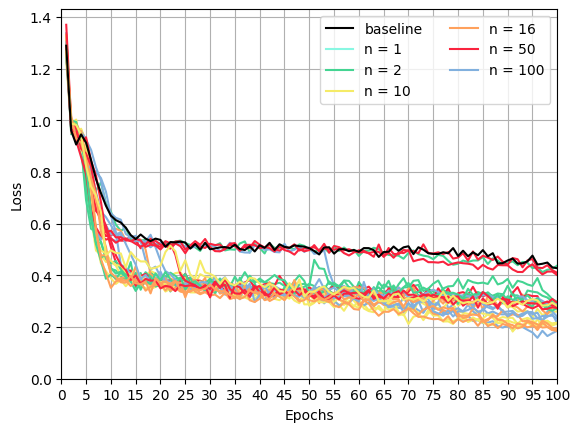

In [53]:
metric = 'loss'

colors = ['#88F7E2', '#44D492', '#F5EB67', '#FFA15C', '#FA233E', '#81b0de']
vocab_colors = {vocab_size: index for index, vocab_size in enumerate(sorted(list({run.vocab_size for run in runs})))}
max_len_colors = {max_len: index for index, max_len in enumerate(sorted(list({run.max_len for run in runs})))}

for run in runs:
    n_train_epochs = [float(epoch['epoch']) for epoch in run.train_epochs]
    train_losses = [float(epoch[metric]) for epoch in run.train_epochs]

    if run.baseline:
        zorder = 100
        color='black'
    else:
        zorder = None
        color = colors[vocab_colors[run.vocab_size]]
    
    plt.plot(n_train_epochs, train_losses, color=color, zorder=zorder)

plt.xlim(0,100)
plt.xticks(range(0,101,5))
plt.xlabel('Epochs')

plt.ylim(0)
plt.yticks([i / 100 for i in range(0,151,20)]) 
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Loss')

handles= [mlines.Line2D([], [], color=colors[index], label=f"n = {variable}") for variable, index in vocab_colors.items()]
handles.insert(0,mlines.Line2D([], [], color='black', label=f"baseline"))
plt.legend(handles=handles, ncol=2)
plt.grid()
plt.show()